# Power Analysis

### Outline
- Sampling distributions and standard errors
- Confidence intervals for average treatment effects
- Power analysis
 - Type I errors
 - Type II errors
 - Type M errors

If you have difficulty invoking load_ext, try doing `pip install rpy2 --upgrade` in your command line and restarting the Jupyter Python kernel.

In [1]:
%load_ext rpy2.ipython

In [81]:
%%R
# First time users: install packages by uncommenting the following line.
#install.packages(c('dplyr', 'ggplot2', 'foreach', 'lmtest', 'sandwich', 'doMC'))

library('plyr')
library('dplyr')
library('ggplot2')
library('foreach')
library('lmtest')
library('sandwich')
library('broom')

options(digits=3)

setwd('~/www-15-tutorial')

## Sampling distributions and standard errors

In [ ]:
#######################################################
##### Sampling distributions and standard errors ######
#######################################################

# In an experiment we're interested min the difference of two averages.
# Our certainty about the value of an average depends on the number of
# samples we have. Before we dive into the variation we see in the
# difference of two means, let's look at the variance of a single variable.

# Consider the mean of a bernoulli random variable, where we flip a coin
# that lands on 1 with probability p, and 0 with probability (1-p).

# We flip a coin N times, observe the average number of times it lands on 1,
# and take measurements of this mean num.replications times.


### Sampling distribution of an average
- Hypothetical experiment: what is the average number of heads for biased coin with p = 0.2 after 100 coin flips?
- Can observe through simulation: how is the average distributed when you replicate the experiment 2000 times? This is called the sampling distribution

 2.5% 97.5% 
 0.12  0.28 


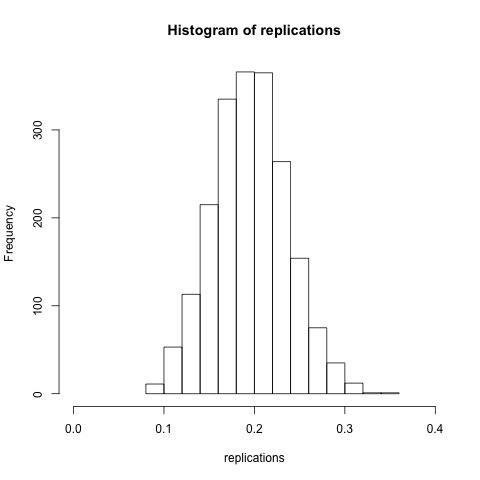

In [90]:
%%R
N <- 100
p <- 0.2
num.replications <- 2000
replications <- replicate(num.replications, mean(rbinom(N, 1, p)))

print(quantile(replications, c(0.025, 0.975)))  # 95% interval
hist(replications, xlim=c(0,0.4))               # histogram

## Standard error
- The standard error is the standard deviation of the sampling distribution

In [97]:
%%R
# Alternatively, we can use the standard deviation of the sampling distribution.
# which is approximately normal for sufficiently large N.
est.se <- sd(replications)
mean.est.p <- mean(replications)
mean.est.p
est.se
c(mean.est.p - 1.96*est.se, mean.est.p + 1.96*est.se)

[1] 0.120 0.281


## Estimating standard error

- The standard deviation of $k$ draws from a Bernoulli distribution is approximated by:

  $$\sigma = \sqrt{\frac{p(p-1)}{N}}$$

- This is the standard error for our experiment!
- 95% confidence interval is $z_{\alpha/2}\text{SE} = 1.96\text{SE}$

In [104]:
%%R
single.trial <- rbinom(N, 1, p)
p.single.trial <- mean(single.trial)

# normal approximation of the SE of a binomial
se <- sqrt(p.single.trial*(1-p.single.trial)/N)
se

[1] 0.0421


In [107]:
%%R
# norm approx 95% CI
c(p.single.trial - 1.96*se, p.single.trial + 1.96*se)

[1] 0.148 0.312


## Relationship between N and CI width

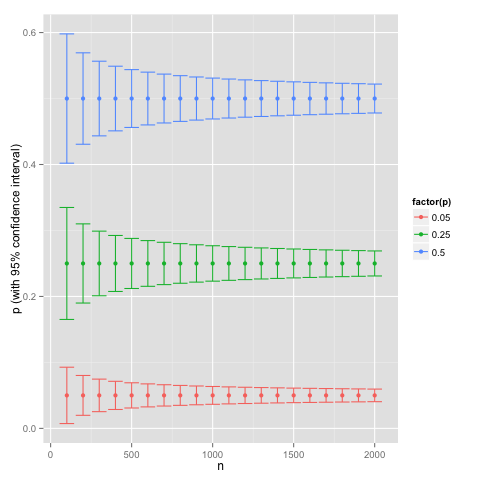

In [108]:
%%R
# let's construct the confidence intervals for p for a few values of p, N
d <- expand.grid(p=c(0.05, 0.25, 0.5), n=seq(100, 2000, 100))
d <- d %>% mutate(se=sqrt(p*(1-p)/n))

qplot(n, p, data=d, color=factor(p),
  ylab='p (with 95% confidence interval)') +
  geom_errorbar(aes(ymin=p-1.96*se, ymax=p+1.96*se))

## Relationship between N and CI width

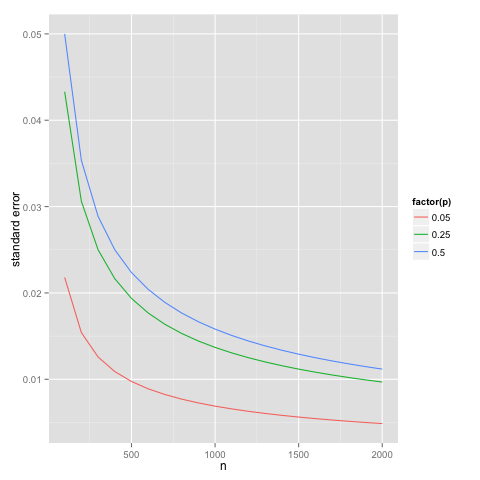

In [39]:
%%R
# you can see that the standard error rapidly diminishes with N.
# (sqrt(1/n), in particular).
qplot(n, se, data=d, color=factor(p), geom='line', ylab='standard error')

## Sampling distribution for an average treatment effects
- Consider simulated experiment with binary treatment, $D$:

  $$y = \mu + D*\delta + \epsilon$$
  
- $\delta$ is the average treatment effect (ATE)

In [118]:
%%R
run.experiment <- function(n, ate) {
  data.frame(
    y0=rnorm(n, mean=10, sd=3)
  ) %>%
  mutate(
    y1=y0 + ate,
    D=rbinom(n, 1, 0.5),
    y=D*y1 + (1-D)*y0
  )
}

my.experiment <- run.experiment(2000, 2.0)

head(my.experiment)

     y0    y1 D     y
1 16.96 18.96 1 18.96
2  5.82  7.82 1  7.82
3 13.63 15.63 0 13.63
4 13.22 15.22 1 15.22
5  8.31 10.31 0  8.31
6 13.19 15.19 0 13.19


### Distribution of outcomes for simulated subjects

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.
stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


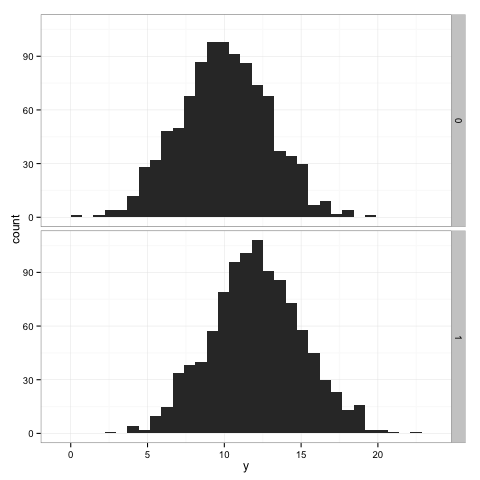

In [120]:
%%R
qplot(y, geom='histogram', data=my.experiment, facets=D~.) + theme_bw()

## Sampling distribution of estimated ATE

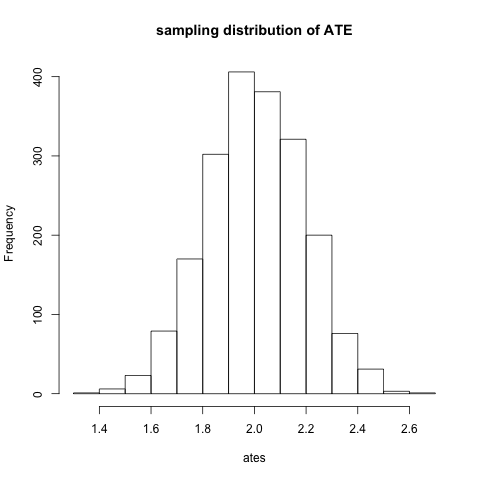

In [123]:
%%R
est.ate <- function(exp) {
  mean(exp[exp$D==1,]$y) - mean(exp[exp$D==0,]$y)
}

num.replications <- 2000
ates <- replicate(
  num.replications,
  est.ate(run.experiment(n=1e3, 2.0)))

hist(ates, main='sampling distribution of ATE')

## Estimating SEs: Using a t-test

In [17]:
%%R
# 95% of the estimated treated effects lie within this range
quantile(ates, c(0.025, 0.975))

# Large sample approximations let us make statements about the
# variance of the ATE over different (similar) populations (or
# possible randomizations).

compute.ate(my.experiment)
with(my.experiment, t.test(y[D==1], y[D==0]))


	Welch Two Sample t-test

data:  y[D == 1] and y[D == 0]
t = 8.77, df = 495, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.77 2.80
sample estimates:
mean of x mean of y 
    12.21      9.92 



## Estimating SEs: Using a linear model

In [82]:
%%R
# or via linear regression
m <- lm(y ~ D, data=my.experiment)
coeftest(m)
# take the SE for D, multiply by 1.96, e.g.,
est.ate <- coeftest(m)['D', 'Estimate']
est.se <- coeftest(m)['D', 'Std. Error']

c(est.ate-1.96*est.se, est.ate+1.96*est.se)

[1] 0.818 1.542


## Estimating SEs: Using the bootstrap


 2.5% 97.5% 
 1.81  2.28 


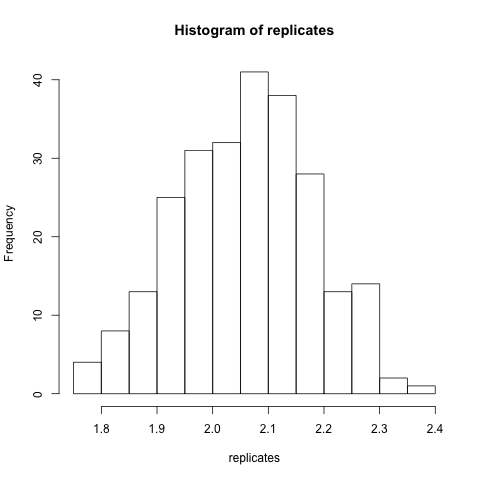

In [134]:
%%R
source('css_stats.R')

weighted.est.ate <- function(exp) {
  m <- lm(y ~ D, data=exp, weights=.weights)
  coeftest(m)['D', 'Estimate']
}

replicates <- iid.bootstrap(my.experiment, weighted.est.ate)
print(quantile(replicates, c(0.025, 0.975)))
hist(replicates)


In [26]:
%%R

# Here is a function that returns confidence intervals for a dataframe
# with an outcome y and a binary treatment D. We will use this later.

get.ci <- function(experiment) {
  t <- coeftest(lm(y ~ D, data=experiment))
  est.ate <- t['D', 'Estimate']
  est.se <- t['D', 'Std. Error']
  p.value <- t['D', 'Pr(>|t|)']
  return(list(est.ate=est.ate, est.se=est.se, p.value=p.value))
}

get.ci(my.experiment)

$est.ate
[1] 2.29

$est.se
[1] 0.261

$p.value
[1] 2.75e-17



## Type I, II, M errors
- Type I error: Finding a "significant" difference when there is no difference.
- Type II error: Failure to find a "significant" difference.
- Type M error: Measuring an ATE that is too large

In [ ]:
# For smaller sample sizes and/or heavily skewed outcomes, or non-iid data,
# it is recommended to use other methods like the bootstrap (covered later),
# randomization inference, or robust cluster standard errors.

#################################################
##### Type I, Type II, and Type M Errors  #######
#################################################

# To investigate the variation we get when repeating a hypothetical experiment
# multiple times, we simulate multiple replications of a randomized trial.

In [27]:
%%R
# This function runs an experiment multiple times (num.replications),
# and generates a dataframe containing estimates of the treatment effects and
# standard errors for each experiment, sorted by the size of the effect.
replicate.experiment <- function(sim.func, params, num.replications=100) {
  # Note: you can parallelize this process below by using %dopar% if
  # you have the 'doMC' package installed.
  exps <- foreach(replication=1:num.replications, .combine=rbind) %do% {
  	as.data.frame(get.ci(do.call(sim.func, params)))
  }
  exps <- exps[order(exps$est.ate),]
  exps <- mutate(exps,
    rank=1:nrow(exps),
    significant=sign(est.ate-1.96*est.se)==sign(est.ate+1.96*est.se)
  )
  exps
}

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


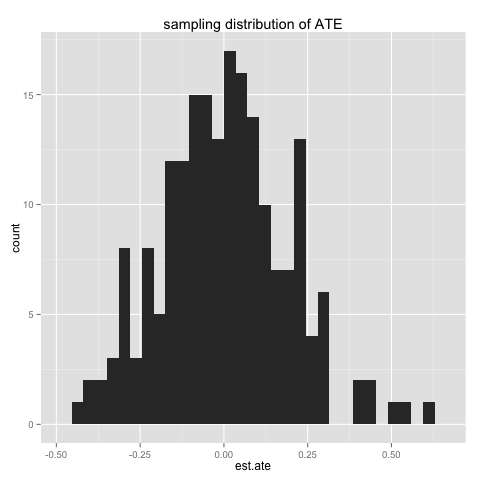

In [49]:
%%R
#####
# Type I error: detecting a "statistically significant" effect when
# there is no effect.

# run 300 trials of an experiment with no ATE
null.experiments <- replicate.experiment(run.experiment,
  list(n=1e3, ate=0.0),
  num.replications=200)

qplot(est.ate, data=null.experiments, main="sampling distribution of ATE")

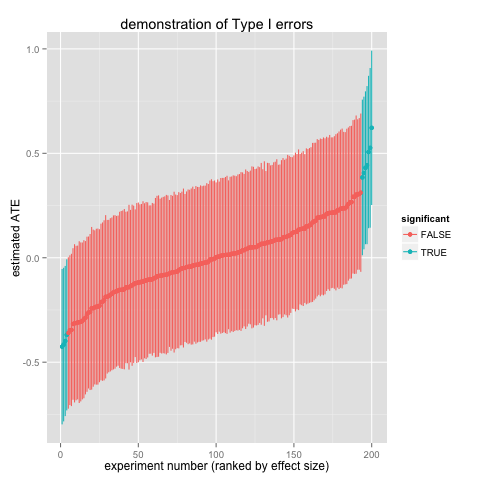

In [50]:
%%R
# plot the results of the experiments, rank-ordered by effect size, along
# with their confidence intervals. Experiments that are "significant" have
# confidence intervals that do not cross zero and are highlighted in blue.
qplot(rank, est.ate, data=null.experiments, color=significant,
  xlab='experiment number (ranked by effect size)', ylab='estimated ATE',
  main='demonstration of Type I errors') +
  geom_pointrange(aes(ymin=est.ate-1.96*est.se, ymax=est.ate+1.96*est.se)) +
  geom_point()

In [51]:
%%R
# This is the Type I error rate, and it is 0.05 because we use an
# appropriate method for computing confidence intervals.
mean(null.experiments$significant)

[1] 0.055


In [ ]:
# exercise: use R to show that the above proportion not significantly different from 0.05

### Type II errors

# this experiment has a true effect of +0.5 (out of an average, 10)

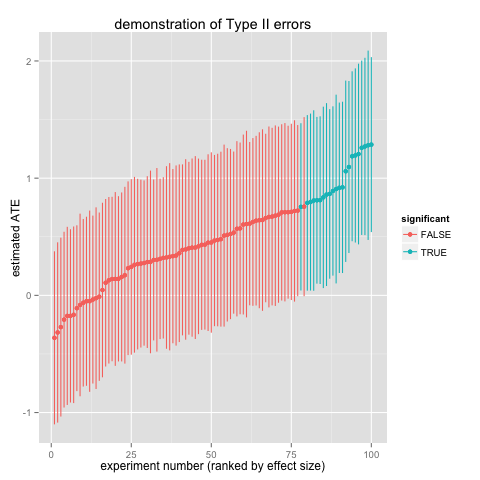

In [53]:
%%R
sad.experiments <- replicate.experiment(run.experiment,
  list(n=250, ate=0.5),
  num.replications=100)

# plot the results of the experiments, rank-ordered by effect size, along
# with their confidence intervals. Experiments that are "significant" have
# confidence intervals that do not cross zero and are highlighted in blue.
qplot(rank, est.ate, data=sad.experiments, color=significant,
  xlab='experiment number (ranked by effect size)', ylab='estimated ATE',
  main='demonstration of Type II errors') +
  geom_pointrange(aes(ymin=est.ate-1.96*est.se, ymax=est.ate+1.96*est.se)) +
  geom_point()

In [55]:
%%R
# Fraction of experiments that are statistically significant.
# This is called the statistical power of the experiment.
mean(sad.experiments$significant)

### Type M errors

# when experiments are underpowered, only reporting on significant experiments
# can massively overstate effects.
with(subset(sad.experiments, significant==TRUE), mean(est.ate))

[1] 0.991


In [ ]:
###################################
##### Power analysis           ####
###################################

# In earlier slides we came up with a few expressions for the standard
# error.  Let's consider that again.

# Let's add two new agruments, the proportion treated, and the
# standard deviation of the outcome variable.

In [57]:
%%R
run.experiment2 <- function(n, ate, prop.treated=0.5, y.sd=3) {
  data.frame(
    y0=rnorm(n, mean=10, sd=y.sd)
  ) %>%
  mutate(
    y1=y0 + ate,
    D=rbinom(n, 1, prop.treated),
    y=D*y1 + (1-D)*y0
  )
}

Let's simulate a few replications with varying proportions of
users assigned to treatment and control.

In [74]:
%%R
exps <- foreach(p=seq(0.05, 0.95, 0.05), .combine=rbind) %do% {
  varying.prop = list(n=1e3, ate=1, prop.treated=p, y.sd=3)
  replications <- replicate.experiment(
    sim.func=run.experiment2,
    params=varying.prop,
    num.replications=250
  )
  data.frame(
    prop.treated=p,
    sim.se=sd(replications$est.ate),
    sim.ate=mean(replications$est.ate),
    norm.est.se=head(replications$est.se, 1)
  )
}

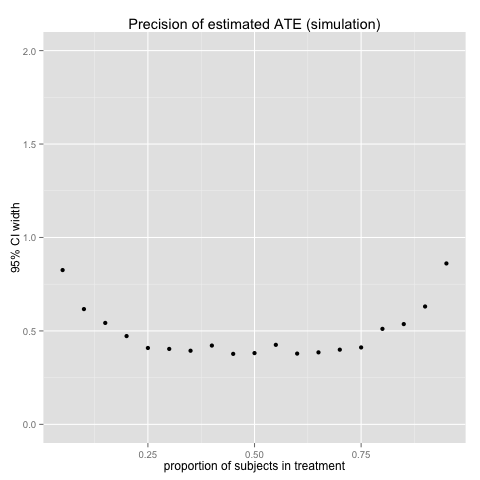

In [76]:
%%R
qplot(prop.treated, 1.96*sim.se, data=exps,
      ylab='95% CI width', xlab='proportion of subjects in treatment',
      ylim=c(0, 2.0), main='Precision of estimated ATE (simulation)')

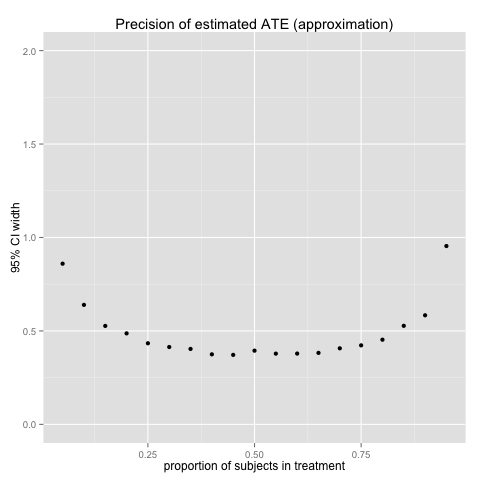

In [79]:
%%R
qplot(prop.treated, 1.96*norm.est.se, data=exps,
       ylab='95% CI width', xlab='proportion of subjects in treatment',
       ylim=c(0,2.0), main='Precision of estimated ATE (approximation)')

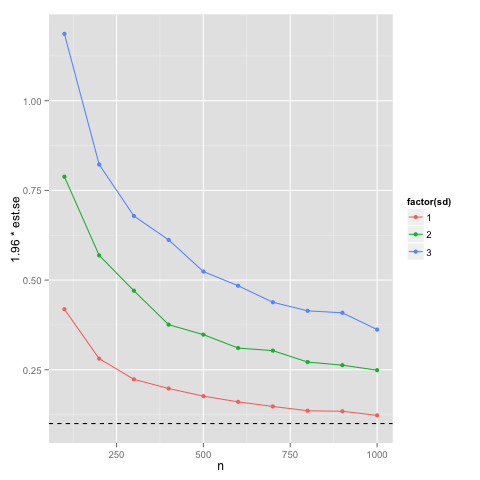

In [80]:
%%R
# We will use a stripped down version that doesn't use replications for
# demonstration purposes, using get.ci() with a single trial for each
# parameterization.

n <- 1e3
true.ate <- 0.1
p=0.5
exps <- foreach(n=seq(100, 1e3, 1e2), .combine=rbind) %do% {
  foreach(my.sd=c(1, 2, 3), .combine=rbind) %do% { 
    my.experiment <- run.experiment2(
      n=n, ate=1, prop.treated=0.5, y.sd=my.sd)
    my.ses <- get.ci(my.experiment)
    data.frame(n=n, sd=my.sd,
               est.ate=my.ses$est.ate,
               est.se=my.ses$est.se)
  }
}

qplot(n, 1.96*est.se, data=exps, color=factor(sd), geom=c('line', 'point')) + geom_hline(aes(yintercept=true.ate), linetype='dashed')


## Exercise 2: Do the same thing with a skewed distribution, like the lognorm
##             (you can generate a log-norm with rlnorm().
##             Do you notice any difference between how big your N has to be
##             in order for the 